<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [2]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import wget
import tqdm

from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
device = torch.device("cpu")

In [4]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists("./datasets/" + images_name):
        print("images not found, downloading...")
        wget.download("http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz", out="./datasets/")
        print("extracting...")
        os.system("")
        print("done")
        assert os.path.exists("./datasets/" + images_name)

    if not os.path.exists("./datasets/" + attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("./datasets/lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk("./datasets/" + images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs, photo_ids, on=('person','imagenum'))

    assert len(df) == len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos = df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [5]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()  # shape - неверный, потом - data = np.transpose(data, (0, 3, 1, 2))


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [6]:
data_train, data_val = train_test_split(data, train_size=0.9, shuffle=True)
print(data_train.shape, data_val.shape);

(11828, 64, 64, 3) (1315, 64, 64, 3)


In [9]:
def draw_faces(dt):
    fig, axs = plt.subplots(3, 3)
    
    for i, ax in enumerate(axs.flat):
        ax.imshow(dt[i])
        ax.axis("off")
    
    fig.set_size_inches(9, 7)
    plt.tight_layout()
    plt.show()

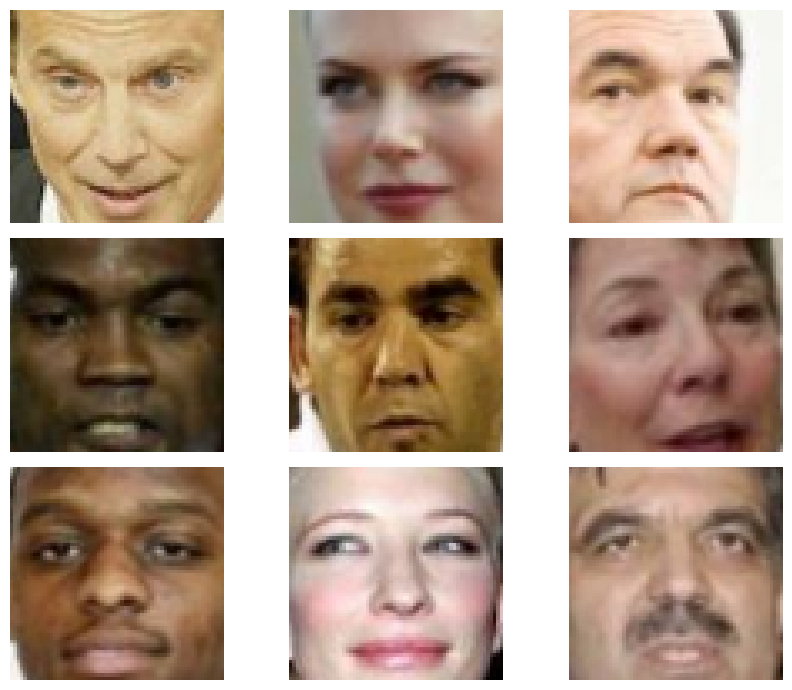

In [7]:
draw_faces(data_train)

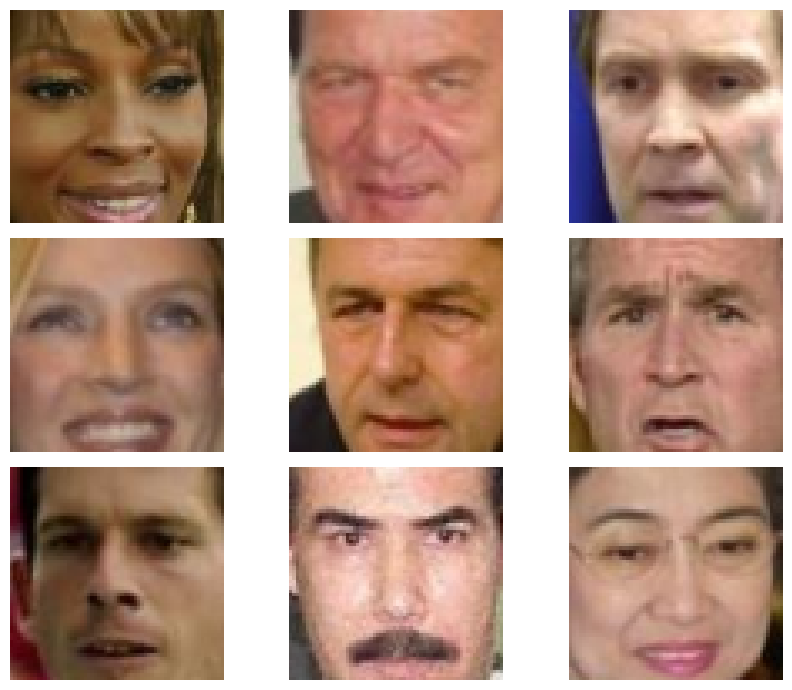

In [8]:
draw_faces(data_val)

In [9]:
data_train.shape

(11828, 64, 64, 3)

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://user-images.githubusercontent.com/50926437/180223287-e7edbcc4-8fe2-4ce3-8879-cc95d9432ce1.png" alt="Autoencoder" width="900" height="450">


^ напомню, что автоэнкодер выглядит вот так

In [29]:
dim_code = 128

In [30]:
data.shape

(13143, 64, 64, 3)

Conv2d:
$$
\frac{h + 2 \cdot \text{padding} - (\text{kernel\_size} - 1) - 1}{\text{stride}} + 1
$$


ConvTranspose2d:
$$
(h - 1) \times \text{stride} - 2 \times \text{padding} + (\text{kernel\_size} - 1) + \text{output\_padding} + 1
$$


In [31]:
f"Conv2d: {(64 + 2 * 1 - (3 - 1) - 1) / 1 + 1}"  # Размерность та же

'Conv2d: 64.0'

In [32]:
f"MaxPool2d: {(64 + 2 * 0 - (2 - 1) - 1) / 2 + 1}"  # По умолчанию padding = 0, уменьшаем размерность в 2 раза

'MaxPool2d: 32.0'

In [33]:
f"ConvTranspose2d: {(64 - 1) * 2 - 2 * 1 + (3 - 1) + 1 + 1}"

'ConvTranspose2d: 128'

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [18]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self._encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64 -> 32
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32 -> 16
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16 -> 8
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8 -> 4 shape: (batch_size, 64, 4, 4)
            
            nn.Flatten(),  # shape: (batch_size, 64 * 4 * 4)
            nn.Linear(64 * 4 * 4, dim_code)  # shape: (batch_size, dim_code)
        )
        
        self._decoder = nn.Sequential(
            nn.Linear(dim_code, 64 * 4 * 4),  # (batch_size, 64 * 4 * 4)
            nn.Unflatten(1, (64, 4, 4)),  # (batch_size, 64, 4, 4)
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4 -> 8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32 -> 64
            nn.Sigmoid()
        )

    def forward(self, x):
        latent_code = self._encoder(deepcopy(x))
        reconstruction = self._decoder(latent_code)

        return reconstruction, latent_code
    
    def sampler(self, x):  # надо!
        return self._decoder(x)

In [10]:
dim_code_2 = 256

class Autoencoder2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self._encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64 -> 32
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32 -> 16
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16 -> 8
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8 -> 4 shape: (batch_size, 256, 4, 4)
            
            nn.Flatten(),  # shape: (batch_size, 256 * 4 * 4)
            nn.Linear(256 * 4 * 4, dim_code_2)  # shape: (batch_size, dim_code)
        )
        
        self._decoder = nn.Sequential(
            nn.Linear(dim_code_2, 256 * 4 * 4),  # (batch_size, 256 * 4 * 4)
            nn.Unflatten(1, (256, 4, 4)),  # (batch_size, 256, 4, 4)
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4 -> 8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8 -> 16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16 -> 32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32 -> 64
            nn.Sigmoid()
        )

    def forward(self, x):
        latent_code = self._encoder(deepcopy(x))
        reconstruction = self._decoder(latent_code)

        return reconstruction, latent_code
    
    def sampler(self, x):  # надо!
        return self._decoder(x)

In [35]:
criterion = nn.BCELoss()
autoencoder = Autoencoder()
optimizer = optim.Adam(autoencoder.parameters(), amsgrad=True)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [7]:
train_loader = torch.utils.data.DataLoader(torch.Tensor(data_train).permute((0, 3, 1, 2)), batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.Tensor(data_val).permute((0, 3, 1, 2)), batch_size=32, shuffle=False)

In [20]:
def train(model, loss_func, optimizer, train_loader, num_epochs=45, get_latent=False):
    losses = []
    latent_array = []
    
    for epoch in tqdm.tqdm(range(num_epochs), desc=f"Process"):
        model.train()
        running_loss = 0.0
        
        for X_batch in train_loader:
            optimizer.zero_grad()
            X_batch = X_batch.to(device)
            reconstruction, latent_v = model(X_batch)
            
            if get_latent:
                latent_array.append(latent_v)
            
            loss = loss_func(reconstruction, X_batch)
            loss.backward()
            
            optimizer.step()
            running_loss += loss.cpu().item()
        avg_loss = running_loss / len(train_loader)
        print('Epoch: {}. Loss: {}'.format(epoch+1,avg_loss))
        losses.append(avg_loss)
    
    if get_latent:
        return losses, latent_array
    return losses

In [38]:
losses = train(autoencoder, criterion, optimizer, train_loader)

Process:   2%|▏         | 1/45 [00:47<34:36, 47.20s/it]

Epoch: 1. Loss: 0.6395509141522485


Process:   4%|▍         | 2/45 [01:33<33:14, 46.39s/it]

Epoch: 2. Loss: 0.6129435618181487


Process:   7%|▋         | 3/45 [02:18<32:19, 46.18s/it]

Epoch: 3. Loss: 0.6091297075555131


Process:   9%|▉         | 4/45 [03:05<31:31, 46.15s/it]

Epoch: 4. Loss: 0.6071545973017409


Process:  11%|█         | 5/45 [03:51<30:43, 46.10s/it]

Epoch: 5. Loss: 0.6057977006242082


Process:  13%|█▎        | 6/45 [04:38<30:13, 46.50s/it]

Epoch: 6. Loss: 0.60474885605477


Process:  16%|█▌        | 7/45 [05:27<29:57, 47.31s/it]

Epoch: 7. Loss: 0.6041315521742846


Process:  18%|█▊        | 8/45 [06:14<29:11, 47.34s/it]

Epoch: 8. Loss: 0.6035949268856564


Process:  20%|██        | 9/45 [07:01<28:21, 47.26s/it]

Epoch: 9. Loss: 0.6032277445535402


Process:  22%|██▏       | 10/45 [07:47<27:21, 46.91s/it]

Epoch: 10. Loss: 0.6028059240934011


Process:  24%|██▍       | 11/45 [08:34<26:26, 46.66s/it]

Epoch: 11. Loss: 0.6024649628110834


Process:  27%|██▋       | 12/45 [09:20<25:34, 46.50s/it]

Epoch: 12. Loss: 0.6021553703256556


Process:  29%|██▉       | 13/45 [10:06<24:44, 46.38s/it]

Epoch: 13. Loss: 0.6018443366965732


Process:  31%|███       | 14/45 [10:52<23:57, 46.37s/it]

Epoch: 14. Loss: 0.6015854175026353


Process:  33%|███▎      | 15/45 [11:38<23:11, 46.37s/it]

Epoch: 15. Loss: 0.6012268111512468


Process:  36%|███▌      | 16/45 [12:25<22:23, 46.32s/it]

Epoch: 16. Loss: 0.6009977100668726


Process:  38%|███▊      | 17/45 [13:11<21:35, 46.27s/it]

Epoch: 17. Loss: 0.6008133145602974


Process:  40%|████      | 18/45 [13:57<20:47, 46.22s/it]

Epoch: 18. Loss: 0.600774917248133


Process:  42%|████▏     | 19/45 [14:43<20:01, 46.21s/it]

Epoch: 19. Loss: 0.6005172127001994


Process:  44%|████▍     | 20/45 [15:29<19:14, 46.19s/it]

Epoch: 20. Loss: 0.6003835826306729


Process:  47%|████▋     | 21/45 [16:15<18:25, 46.07s/it]

Epoch: 21. Loss: 0.600292768188425


Process:  49%|████▉     | 22/45 [17:01<17:38, 46.00s/it]

Epoch: 22. Loss: 0.6001662075519562


Process:  51%|█████     | 23/45 [17:47<16:50, 45.93s/it]

Epoch: 23. Loss: 0.6001283776115727


Process:  53%|█████▎    | 24/45 [18:32<16:03, 45.89s/it]

Epoch: 24. Loss: 0.5999249648403477


Process:  56%|█████▌    | 25/45 [19:18<15:17, 45.86s/it]

Epoch: 25. Loss: 0.5998761122291153


Process:  58%|█████▊    | 26/45 [20:04<14:30, 45.83s/it]

Epoch: 26. Loss: 0.59976837844462


Process:  60%|██████    | 27/45 [20:50<13:46, 45.91s/it]

Epoch: 27. Loss: 0.5996743480901461


Process:  62%|██████▏   | 28/45 [21:36<12:59, 45.87s/it]

Epoch: 28. Loss: 0.5996320447406254


Process:  64%|██████▍   | 29/45 [22:22<12:13, 45.85s/it]

Epoch: 29. Loss: 0.5995262337697519


Process:  67%|██████▋   | 30/45 [23:07<11:27, 45.83s/it]

Epoch: 30. Loss: 0.5994822635843947


Process:  69%|██████▉   | 31/45 [23:53<10:41, 45.81s/it]

Epoch: 31. Loss: 0.599401059021821


Process:  71%|███████   | 32/45 [24:39<09:55, 45.80s/it]

Epoch: 32. Loss: 0.5993347947661941


Process:  73%|███████▎  | 33/45 [25:25<09:09, 45.80s/it]

Epoch: 33. Loss: 0.5993509092846432


Process:  76%|███████▌  | 34/45 [26:11<08:23, 45.80s/it]

Epoch: 34. Loss: 0.5992339398409869


Process:  78%|███████▊  | 35/45 [26:56<07:37, 45.79s/it]

Epoch: 35. Loss: 0.5991760221687523


Process:  80%|████████  | 36/45 [27:42<06:52, 45.79s/it]

Epoch: 36. Loss: 0.59913314564808


Process:  82%|████████▏ | 37/45 [28:28<06:06, 45.77s/it]

Epoch: 37. Loss: 0.5990663689536018


Process:  84%|████████▍ | 38/45 [29:14<05:20, 45.76s/it]

Epoch: 38. Loss: 0.5990155724254814


Process:  87%|████████▋ | 39/45 [29:59<04:34, 45.77s/it]

Epoch: 39. Loss: 0.5989875588868115


Process:  89%|████████▉ | 40/45 [30:45<03:48, 45.76s/it]

Epoch: 40. Loss: 0.598947523735665


Process:  91%|█████████ | 41/45 [31:32<03:03, 45.94s/it]

Epoch: 41. Loss: 0.5989022290384447


Process:  93%|█████████▎| 42/45 [32:17<02:17, 45.89s/it]

Epoch: 42. Loss: 0.5988764086285153


Process:  96%|█████████▌| 43/45 [33:03<01:31, 45.84s/it]

Epoch: 43. Loss: 0.5988224332397049


Process:  98%|█████████▊| 44/45 [33:49<00:45, 45.80s/it]

Epoch: 44. Loss: 0.5988052719348186


Process: 100%|██████████| 45/45 [34:35<00:00, 46.11s/it]

Epoch: 45. Loss: 0.5987688003359615


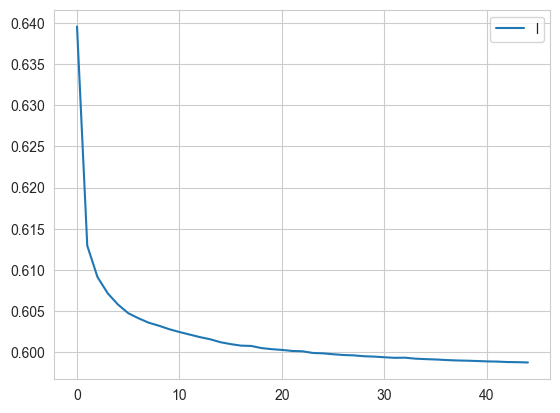

In [39]:
plt.plot(losses)
plt.legend("loss");

In [40]:
if not os.path.exists("./models/Autoencoder_Face.pth"):
    torch.save(autoencoder, "./models/Autoencoder_Face.pth")
    print("model saved...")

model saved...


Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [47]:
if os.path.exists("./models/Autoencoder_Face.pth"):
    autoencoder = torch.load("./models/Autoencoder_Face.pth", weights_only=False)
    print("loaded...")


loaded...


In [48]:
autoencoder.eval()
vl = next(iter(val_loader))

face_images = [vl[i] for i in range(9)]

with torch.no_grad():
    predictions, latent = autoencoder(vl)
    prediction_faces = [predictions[i] for i in range(9)]
#  prediction_faces[0].shape - torch.Size([3, 64, 64])

In [8]:
def to_imshow(iterable):
    result = list(map(lambda x: x.permute((1, 2, 0)), iterable))
    assert len(result) == 9, "Картинок должно быть 9"
    return result

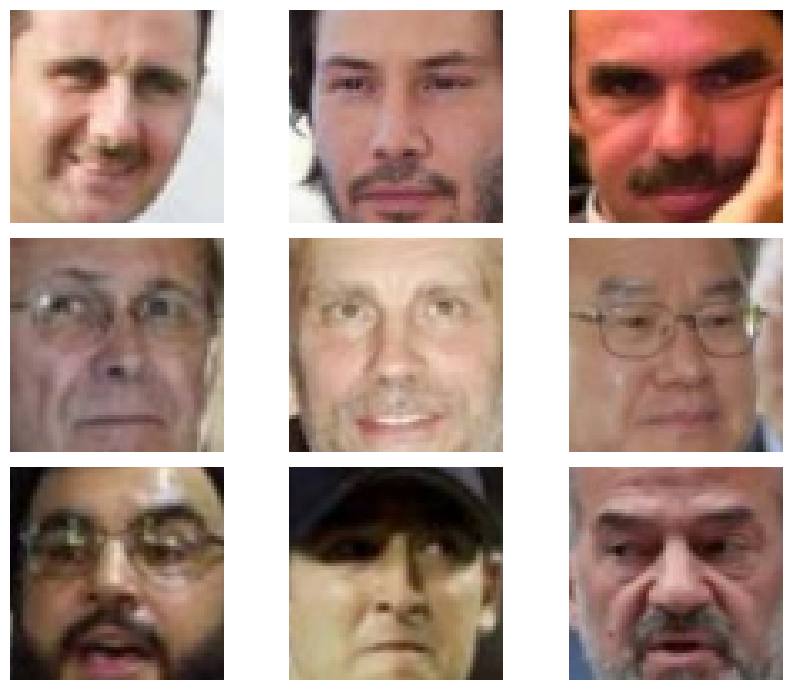

In [50]:
draw_faces(to_imshow(face_images))  # plt.imshow(принимаем другой формат)

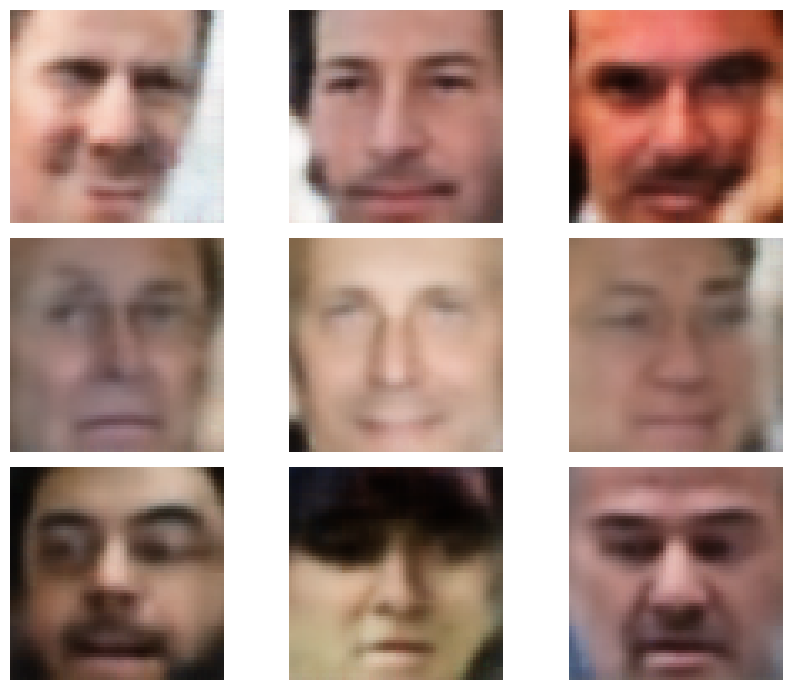

In [51]:
draw_faces(to_imshow(prediction_faces))

Not bad, right?

Хи-хи, Ха-ха

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

**Подсказка:** Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [60]:
z = np.random.randn(9, dim_code)  # сгенерируем 25 рандомных векторов размера latent_space

with torch.no_grad():
    output = autoencoder.sampler(torch.Tensor(z))
output.shape

torch.Size([9, 3, 64, 64])

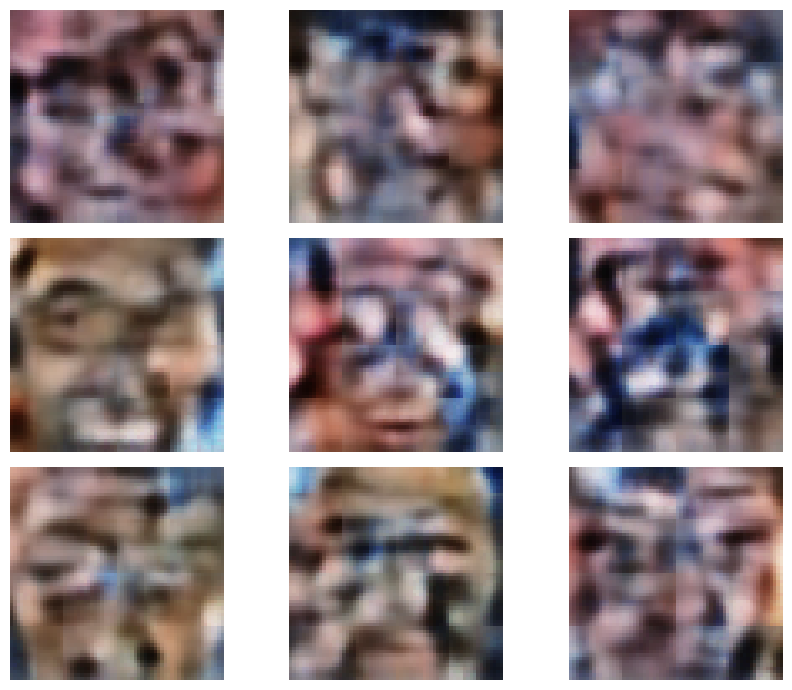

In [61]:
draw_faces(to_imshow(output))

Плохое качество, так как вектора распределены неравномерно

Для создания нормального распределения в библиотеке Numpy используется функция random.normal()
Синтаксис функции: `numpy.random.normal(loc, scale, size)`

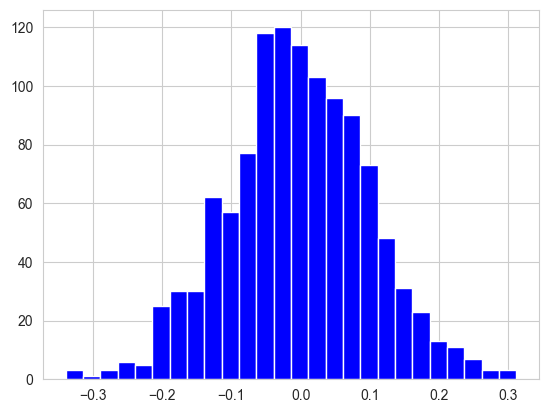

In [77]:
rand_vector = np.random.normal(0, 0.1, (9, dim_code))
plt.hist(rand_vector.flatten(), bins='auto', color='b')
plt.show()

In [78]:
with torch.no_grad():
    output = autoencoder.sampler(torch.Tensor(rand_vector))
output.shape

torch.Size([9, 3, 64, 64])

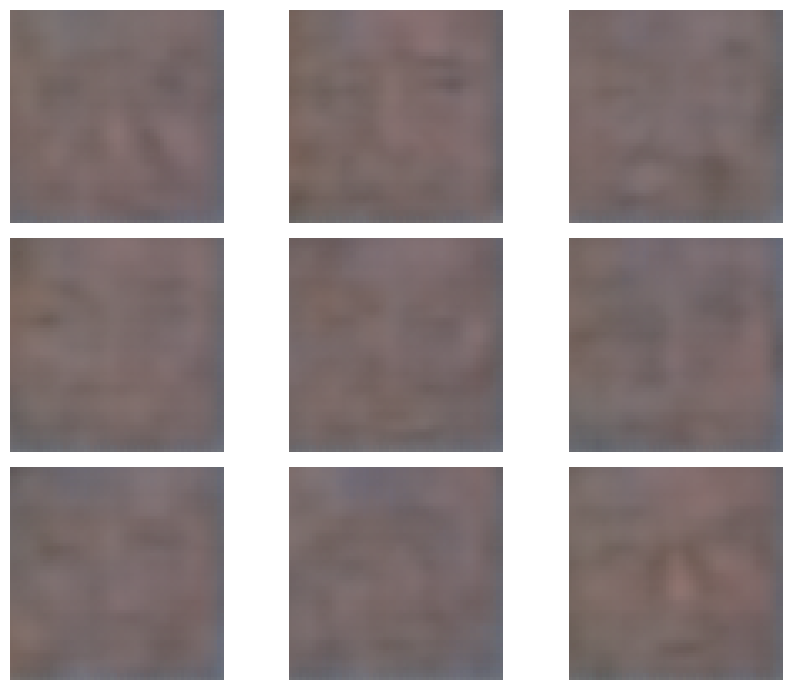

In [79]:
draw_faces(to_imshow(output))

Уже лучше, но всё ещё плохо. Нужно точно определить как распределены картинки лиц.

**Пример:** допустим, у вас есть автоэнкодер, который обучен на изображениях лиц. У него есть энкодер, который переводит изображение в латентное пространство, и декодер, который преобразует латентный вектор обратно в изображение. Задача в том, чтобы понять, как распределены латентные векторы реальных лиц и подогнать распределение случайных векторов под это распределение.

Для этого нам и нужно возвращать `reconstruction, latent_code`

In [21]:
criterion_2 = nn.BCELoss()
autoencoder_2 = Autoencoder2()
optimizer_2 = optim.Adam(autoencoder_2.parameters(), amsgrad=True)

In [22]:
losses_2, latent_vectors = train(autoencoder_2, criterion_2, optimizer_2, train_loader, num_epochs=25, get_latent=True)

Process:   4%|▍         | 1/25 [01:46<42:24, 106.00s/it]

Epoch: 1. Loss: 0.6256044606904726


Process:   8%|▊         | 2/25 [03:31<40:25, 105.47s/it]

Epoch: 2. Loss: 0.6091775813618222


Process:  12%|█▏        | 3/25 [05:16<38:35, 105.24s/it]

Epoch: 3. Loss: 0.6057294792420155


Process:  16%|█▌        | 4/25 [07:00<36:47, 105.10s/it]

Epoch: 4. Loss: 0.6041015151384714


Process:  20%|██        | 5/25 [08:45<35:00, 105.04s/it]

Epoch: 5. Loss: 0.6029310290877884


Process:  24%|██▍       | 6/25 [10:30<33:15, 105.03s/it]

Epoch: 6. Loss: 0.6021189717022148


Process:  28%|██▊       | 7/25 [12:15<31:29, 105.00s/it]

Epoch: 7. Loss: 0.601293738146086


Process:  32%|███▏      | 8/25 [14:00<29:44, 105.00s/it]

Epoch: 8. Loss: 0.6008572784630029


Process:  36%|███▌      | 9/25 [15:45<27:59, 104.96s/it]

Epoch: 9. Loss: 0.6003705540218869


Process:  40%|████      | 10/25 [17:30<26:14, 104.95s/it]

Epoch: 10. Loss: 0.5999914952226587


Process:  44%|████▍     | 11/25 [19:15<24:29, 104.95s/it]

Epoch: 11. Loss: 0.5996988401219652


Process:  48%|████▊     | 12/25 [21:00<22:43, 104.92s/it]

Epoch: 12. Loss: 0.5996214660438332


Process:  52%|█████▏    | 13/25 [22:45<20:58, 104.92s/it]

Epoch: 13. Loss: 0.5992255708655796


Process:  56%|█████▌    | 14/25 [24:32<19:20, 105.48s/it]

Epoch: 14. Loss: 0.5990388395013035


Process:  60%|██████    | 15/25 [26:18<17:38, 105.85s/it]

Epoch: 15. Loss: 0.5990137868636364


Process:  64%|██████▍   | 16/25 [28:04<15:51, 105.68s/it]

Epoch: 16. Loss: 0.5987646918039065


Process:  68%|██████▊   | 17/25 [29:50<14:08, 106.00s/it]

Epoch: 17. Loss: 0.5986023071649912


Process:  72%|███████▏  | 18/25 [31:35<12:19, 105.65s/it]

Epoch: 18. Loss: 0.598547074601457


Process:  76%|███████▌  | 19/25 [33:20<10:32, 105.41s/it]

Epoch: 19. Loss: 0.5984324506811194


Process:  80%|████████  | 20/25 [35:05<08:46, 105.32s/it]

Epoch: 20. Loss: 0.5982225403592393


Process:  84%|████████▍ | 21/25 [36:50<07:00, 105.17s/it]

Epoch: 21. Loss: 0.5981747343733504


Process:  88%|████████▊ | 22/25 [38:35<05:15, 105.07s/it]

Epoch: 22. Loss: 0.5979952594718417


Process:  92%|█████████▏| 23/25 [40:20<03:29, 104.98s/it]

Epoch: 23. Loss: 0.5979953040947785


Process:  96%|█████████▌| 24/25 [42:04<01:44, 104.91s/it]

Epoch: 24. Loss: 0.5979205859673989


Process: 100%|██████████| 25/25 [43:49<00:00, 105.19s/it]

Epoch: 25. Loss: 0.5976979073640463


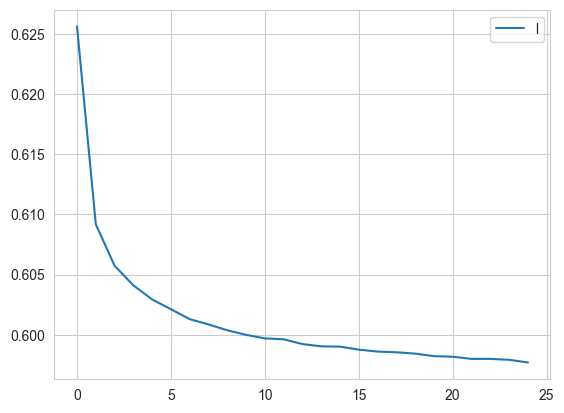

In [23]:
plt.plot(losses_2)
plt.legend("loss");

In [35]:
dropped_latents = [vector for vector in latent_vectors if vector.shape[0] == 32]
stacked_latents = torch.stack(dropped_latents)
stacked_latents.shape

torch.Size([9225, 32, 256])

In [40]:
mean_latent_vector = stacked_latents.mean(dim=0).mean(dim=0)
std_latent_vector = stacked_latents.std(dim=0).mean(dim=0)
real_latent_normal = np.random.normal(mean_latent_vector.detach().numpy(), std_latent_vector.detach().numpy(), (9, dim_code_2))
mean_latent_vector.shape

torch.Size([256])

In [41]:
with torch.no_grad():
    output = autoencoder_2.sampler(torch.Tensor(real_latent_normal))
output.shape

torch.Size([9, 3, 64, 64])

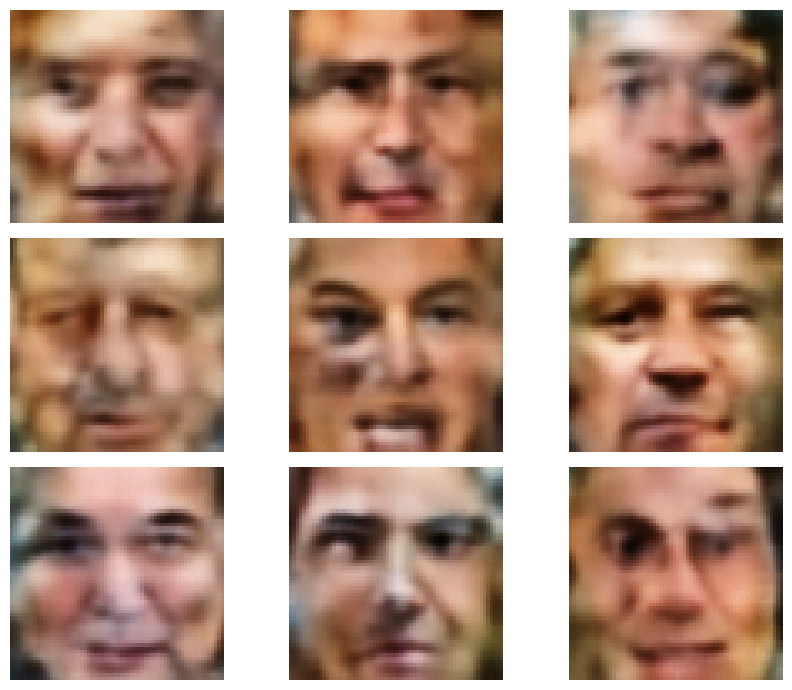

In [42]:
draw_faces(to_imshow(output))

Приколдесно :)

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [13]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [45]:
sad_ind = attrs.sort_values('Smiling', ascending=True).where(attrs['Male'] > 0).dropna().head(20).index
smile_ind = attrs.sort_values('Smiling', ascending=False).where(attrs['Male'] > 0).dropna().head(20).index

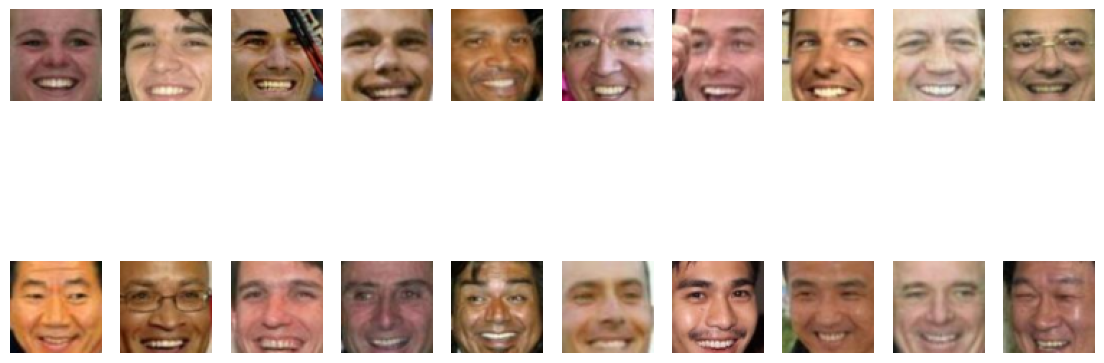

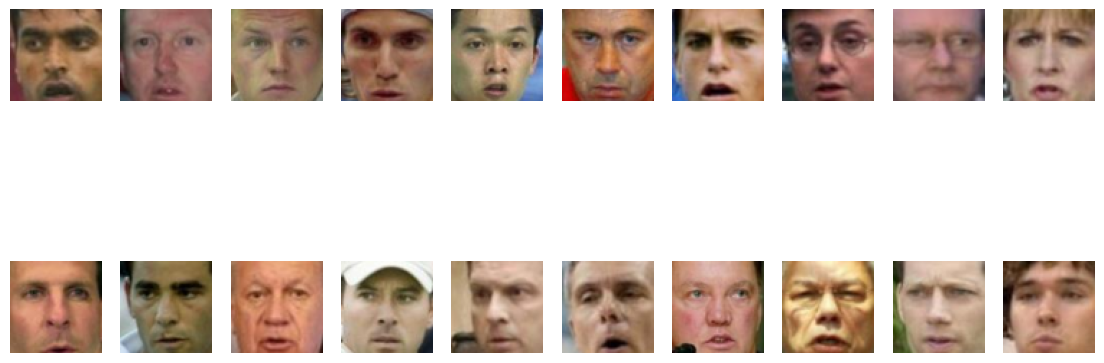

In [52]:
fig_1, axs_1 = plt.subplots(2, 10, figsize=(14, 6))
for i, ax in enumerate(axs_1.flat):
    ax.imshow(data[smile_ind][i])
    ax.axis('off')

fig_2, axs_2 = plt.subplots(2, 10, figsize=(14, 6))
for i, ax in enumerate(axs_2.flat):
    ax.imshow(data[sad_ind][i])
    ax.axis('off')

plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        <определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста",
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

    def encode(self, x):
        <реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma>

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        <реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>

        return reconstruction

    def forward(self, x):
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = <напишите код для KL-дивергенции, пользуясь формулой выше>
    return

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = <binary cross-entropy>
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return <соедините тут две компоненты лосса. Mind the sign!>

И обучим модель:

In [ ]:
criterion = loss_vae

autoencoder = VAE()

optimizer = <Ваш любимый оптимизатор>

In [ ]:
<обучите модель на датасете MNIST>

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 100) for i in range(10)])
output = <скормите z декодеру>
<выведите тут полученные картинки>

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        <определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста",
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

    def encode(self, x, class_num):
        <реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>

        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_num):
        <реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>

        return reconstruction

    def forward(self, x):
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        return mu, logsigma, reconstruction

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
<тут нужно научиться сэмплировать из декодера цифры определенного класса>

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>